This script generates a bar plot using data from a CSV file. The plot compares HypBO to different methods and their performance on various functions.

The script performs the following steps:

1. Reads the data from the CSV files.
2. Prepares the data by dropping unnecessary columns and setting the index.
3. Reorders the columns based on a predefined order.
4. Renames columns for better readability.
5. Defines bar positions and width.
6. Creates the plot by plotting each set of bars.
7. Sets the plot settings such as title, labels, and legend.
8. Displays the plot.


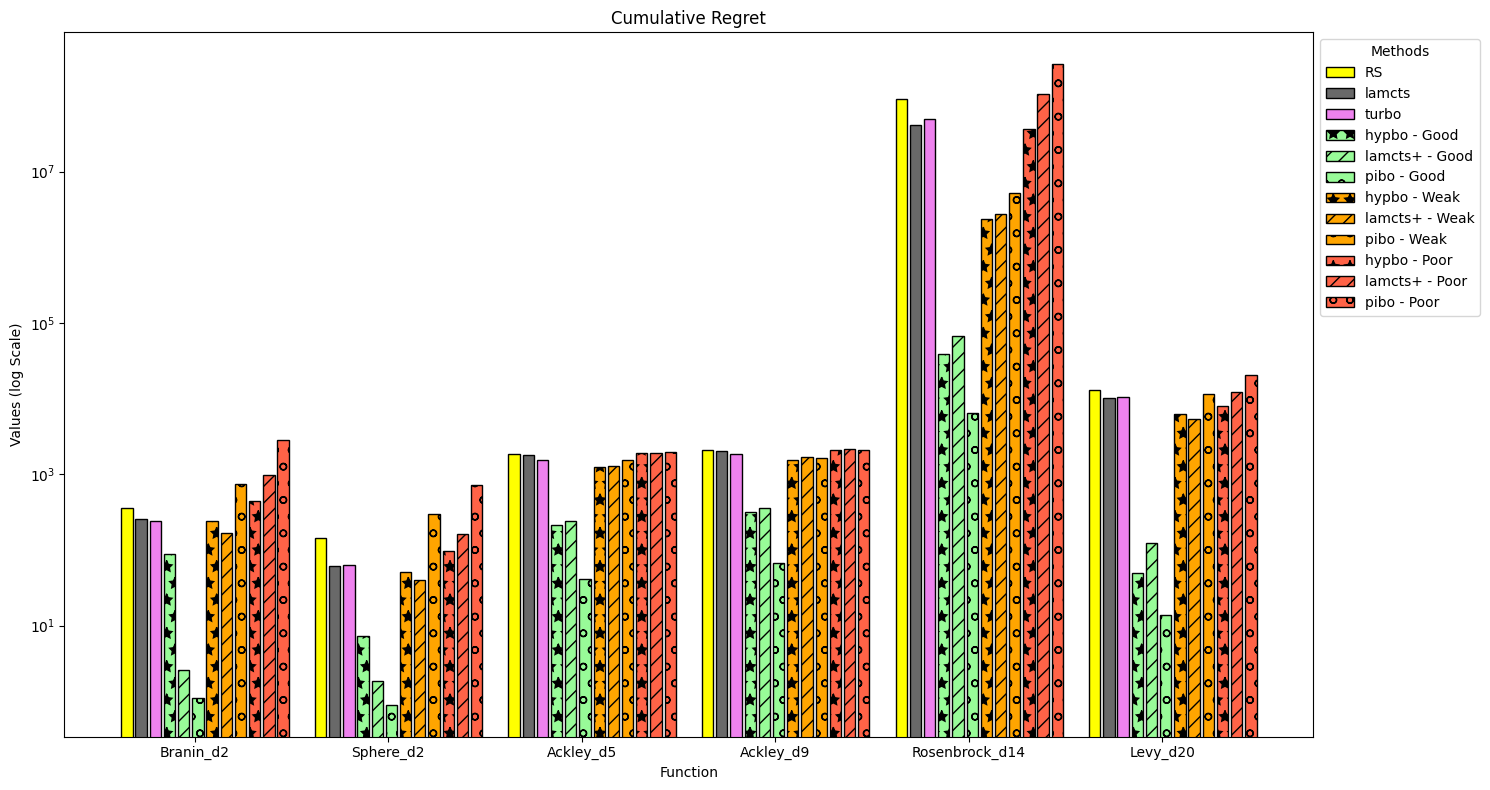

In [36]:
from calendar import c
import matplotlib.pyplot as plt
import pandas as pd

single_hypothesis = True  # Set to True to plot the single hypothesis results.

# Read the data from the csv files.
file_path = 'regret_cum.csv'
data = pd.read_csv(file_path)   # Regret data.
std_data = pd.read_csv('regret_std_cum.csv')    # Standard deviation data.

# Preparing the data.
data = data.drop(data.columns[0], axis=1)  # Drop the first unnamed column.
# Rename certan columns.
data = data.rename(columns={'random_search - No Hypothesis': 'RS'})
data = data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})
data = data.rename(columns={'turbo - No Hypothesis': 'turbo'})
std_data = std_data.rename(columns={'random_search - No Hypothesis': 'RS'})
std_data = std_data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})
std_data = std_data.rename(columns={'turbo - No Hypothesis': 'turbo'})

# Order of the columns to keep in the plot.
ordered_columns = [
    ('RS', 'yellow'),
    ('lamcts', 'dimgrey'),
    ('turbo', 'violet'),
]
# Add the relevant columns for the single or mixed hypothesis results.
if single_hypothesis:
    ordered_columns += [
        ('hypbo - Good', 'palegreen'),
        ('lamcts+ - Good', 'palegreen'),
        ('pibo - Good', 'palegreen'),
        ('hypbo - Weak', 'orange'),
        ('lamcts+ - Weak', 'orange'),
        ('pibo - Weak', 'orange'),
        ('hypbo - Poor', 'tomato'),
        ('lamcts+ - Poor', 'tomato'),
        ('pibo - Poor', 'tomato'),
    ]
else:
    ordered_columns += [
        ('hypbo - Poor_Good', 'skyblue'),
        ('lamcts+ - Good_Poor', 'skyblue'),
        ('hypbo - Weak_Good', 'palegreen'),
        ('lamcts+ - Good_Weak', 'palegreen'),
        ('hypbo - Poor_Weak', 'orange'),
        ('lamcts+ - Weak_Poor', 'orange')
    ]
# Unzip the ordered columns and colors.
ordered_columns, colors = zip(*ordered_columns)
ordered_columns = list(ordered_columns)
colors = list(colors)

# Drop columns that are not in the ordered columns.
for column in data.columns:
    if column not in ordered_columns and column != 'Function':
        data = data.drop(column, axis=1)
        std_data = std_data.drop(column, axis=1)
data = data.set_index('Function')  # Set 'Function' as index.
std_data = std_data.set_index('Function')  # Set 'Function' as index.

# Reorder the data with sorted columns.
data = data[ordered_columns]
std_data = std_data[ordered_columns]

# Define bar positions and width.
bar_width = 0.7 / len(data.columns)
bar_positions = {}

# Creating the plot.
plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.set_yscale('log')    # Set log scale on the y axis.

# Plot each set of bars
space_in_pixels = 1.5  # The desired space between groups of bars, in pixels
dpi = plt.gcf().dpi  # Get the figure's resolution in dots per inch
space = space_in_pixels / dpi  # Convert pixels to coordinates
for i, (method, color) in enumerate(zip(data.columns, colors)):
    hatch = '//' if 'lamcts+' in method else (
        'o' if 'pibo' in method else ('*' if 'hypbo' in method else None))
    bar_position_with_space = [
        x + (bar_width + space) * i for x in range(len(data))]
    plt.bar(bar_position_with_space, data[method],
            width=bar_width, label=method, color=color, hatch=hatch,
            edgecolor='black', linewidth=1,  # Bar border
            # yerr=std_data[method], capsize=5  # Uncomment to add error bars
            )

# Final plot settings
title = 'Simple Regret' if single_hypothesis else 'Simple Regret (Mixed Hypothesis)'
title = title.replace('Simple', 'Cumulative') if 'cum' in file_path else title
plt.title(title)
plt.ylabel(f'Values ({ax.get_yscale()} Scale)')
plt.xlabel('Function')
plt.xticks([r + len(data.columns) // 2 * bar_width for r in range(len(data))],
           data.index, rotation=0)
plt.legend(title='Methods', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [37]:
"""
This script performs a Wilcoxon signed-rank test between different methods using the given data.
It calculates the p-values resulting from the test and displays the mean and median cumulative regrets for each method.
"""

from scipy.stats import wilcoxon


def perform_wilcoxon_test(df, method1, method2):
    """
    Perform Wilcoxon signed-rank test between two methods.

    Parameters:
    - df (DataFrame): The data containing the methods' results.
    - method1 (str): The first method to compare.
    - method2 (str): The second method to compare.

    Returns:
    - p (float): The p-value resulting from the Wilcoxon signed-rank test.
    """
    data1 = df[method1].dropna()
    data2 = df[method2].dropna()
    if len(data1) == 0 or len(data2) == 0:
        return None
    stat, p = wilcoxon(data1, data2)
    return p


p_values = {}


hypbo_variants = []
if single_hypothesis:
    hypbo_variants = ["hypbo - Poor", "hypbo - Weak", "hypbo - Good"]
else:
    hypbo_variants = ["hypbo - Poor_Good",
                      "hypbo - Weak_Good", "hypbo - Poor_Weak"]
methods = [col for col in ordered_columns if col not in hypbo_variants]
# methods = [col.replace('random_search - No Hypothesis', 'RS').replace(
#     'lamcts - No Hypothesis', 'lamcts') for col in methods]   # Rename methods


for hypbo in hypbo_variants:
    for method in methods:
        if method != hypbo:
            p_value = perform_wilcoxon_test(data, hypbo, method)
            if p_value is not None:
                p_values[(hypbo, method)] = p_value


p_values_df = pd.DataFrame([(k[0], k[1], v) for k, v in p_values.items()], columns=[
                           'HypBO Variant', 'Method', 'p-value'])


mean_values = data.mean()
median_values = data.median()


print("Mean Cumulative Regrets:\n", mean_values)
print("\nMedian Cumulative Regrets:\n", median_values)


print("\nWilcoxon Signed-Rank Test P-Values:")
p_values_df_sorted = p_values_df.sort_values(by=['HypBO Variant', 'p-value'])
print(p_values_df_sorted)

Mean Cumulative Regrets:
 RS                1.529956e+07
lamcts            6.811313e+06
turbo             8.320113e+06
hypbo - Good      6.555529e+03
lamcts+ - Good    1.132094e+04
pibo - Good       1.109520e+03
hypbo - Weak      4.013548e+05
lamcts+ - Weak    4.566797e+05
pibo - Weak       8.706709e+05
hypbo - Poor      6.124130e+06
lamcts+ - Poor    1.790894e+07
pibo - Poor       4.368188e+07
dtype: float64

Median Cumulative Regrets:
 RS                1972.186699
lamcts            1921.908084
turbo             1702.500454
hypbo - Good       153.285127
lamcts+ - Good     183.114769
pibo - Good         27.860724
hypbo - Weak      1390.675851
lamcts+ - Weak    1486.607378
pibo - Weak       1603.325455
hypbo - Poor      1990.800265
lamcts+ - Poor    2017.871047
pibo - Poor       2474.475510
dtype: float64

Wilcoxon Signed-Rank Test P-Values:
   HypBO Variant          Method  p-value
18  hypbo - Good              RS  0.03125
19  hypbo - Good          lamcts  0.03125
20  hypbo - Good    

# Wilcoxon Signed-Tests followed by Bonferroni Corrections


In [38]:
import pandas as pd
from scipy.stats import wilcoxon

# Assuming your data is loaded into a DataFrame named 'data'

# Identifying all HypBO columns
hypbo_columns = [col for col in data.columns if 'hypbo' in col.lower()]

# Identifying all other method columns
other_method_columns = [
    col for col in data.columns if col not in hypbo_columns and 'Function' not in col]

# Preparing for multiple comparisons
num_tests = len(hypbo_columns) * len(other_method_columns)
base_alpha = 0.05
alpha = base_alpha / num_tests  # Bonferroni correction

# Performing Wilcoxon signed-rank tests and collecting results
test_results = []

for hypbo_col in hypbo_columns:
    for method_col in other_method_columns:
        # Wilcoxon test
        stat, p_value = wilcoxon(
            data[hypbo_col], data[method_col], alternative='two-sided')
        # Adjusting p-value for multiple comparisons
        p_value_adj = p_value * num_tests
        # Ensuring p-value doesn't exceed 1
        p_value_adj = min(p_value_adj, 1.0)

        test_results.append({
            'HypBO Column': hypbo_col,
            'Comparison Method': method_col,
            'P-Value': p_value,
            'Adjusted P-Value': p_value_adj,
            'Significant at 0.05': p_value_adj < base_alpha
        })

# Converting results to a DataFrame for easier viewing
test_results_df = pd.DataFrame(test_results)

# Sorting by Adjusted P-Value for clarity
test_results_df.sort_values(by='Adjusted P-Value')

,HypBO Column,Comparison Method,P-Value,Adjusted P-Value,Significant at 0.05
0,hypbo - Good,RS,0.03125,0.84375,False
23,hypbo - Poor,lamcts+ - Weak,0.03125,0.84375,False
22,hypbo - Poor,pibo - Good,0.03125,0.84375,False
21,hypbo - Poor,lamcts+ - Good,0.03125,0.84375,False
17,hypbo - Weak,pibo - Poor,0.03125,0.84375,False
16,hypbo - Weak,lamcts+ - Poor,0.03125,0.84375,False
15,hypbo - Weak,pibo - Weak,0.03125,0.84375,False
25,hypbo - Poor,lamcts+ - Poor,0.03125,0.84375,False
12,hypbo - Weak,lamcts+ - Good,0.03125,0.84375,False
11,hypbo - Weak,turbo,0.03125,0.84375,False


# Friedman Test and Post Hoc Analysis


In [41]:
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Preparing the data for analysis
# Drop non-method columns
methods_data = data

# Conducting the Friedman test
friedman_stat, friedman_p_value = friedmanchisquare(
    *[methods_data[col] for col in methods_data.columns])

print("Friedman Test Statistic:", friedman_stat)
print("Friedman Test p-value:", friedman_p_value)

# If Friedman test is significant, proceed with post-hoc analysis
if friedman_p_value < 0.05:
    # Conducting post-hoc analysis using Nemenyi test
    # posthoc_results = sp.posthoc_wilcoxon(methods_data)
    posthoc_results = sp.posthoc_conover_friedman(data)

    # Apply Bonferroni correction to the p-values in the posthoc_results DataFrame
    alpha = 0.05  # Set your chosen significance level
    num_comparisons = len(methods_data.columns)
    bonferroni_alpha = alpha / num_comparisons
    print("Bonferroni Alpha:", bonferroni_alpha)

    # Save the corrected results in a file
    posthoc_results.to_csv('posthoc_results.csv')

    posthoc_results_corrected = posthoc_results.apply(
        lambda p: p < bonferroni_alpha)

    print("Post-hoc Analysis (Nemenyi Test) Results (Bonferroni Corrected):\n",
          posthoc_results_corrected)

    # Save the corrected results in a file
    posthoc_results_corrected.to_csv('posthoc_results_corrected.csv')
else:
    print("Friedman test is not significant; post-hoc analysis is not required.")

Friedman Test Statistic: 60.769230769230774
Friedman Test p-value: 6.670360727783691e-09
Bonferroni Alpha: 0.004166666666666667
Post-hoc Analysis (Nemenyi Test) Results (Bonferroni Corrected):
                    RS  lamcts  turbo  hypbo - Good  lamcts+ - Good  \
RS              False    True   True          True            True   
lamcts           True   False  False          True            True   
turbo            True   False  False          True            True   
hypbo - Good     True    True   True         False           False   
lamcts+ - Good   True    True   True         False           False   
pibo - Good      True    True   True         False           False   
hypbo - Weak     True    True   True          True           False   
lamcts+ - Weak   True    True   True          True            True   
pibo - Weak     False   False  False          True            True   
hypbo - Poor    False   False  False          True            True   
lamcts+ - Poor  False    True   True